## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

It is an A/B test run by an e-commerce website.  my goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

><font color='blue'>let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.`<font color='blue'> Now, store the data of `ab_data.csv` in df.

In [2]:
df=pd.read_csv(r'C:\Users\Carnival\AppData\Local\Temp\Rar$DIa7972.1854\ab_data.csv')

<font color='blue'>The number of rows in the dataset.

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


<font color='blue'>The number of unique users in the dataset.

In [4]:
df.user_id.unique

<bound method Series.unique of 0         851104
1         804228
2         661590
3         853541
4         864975
           ...  
294473    751197
294474    945152
294475    734608
294476    697314
294477    715931
Name: user_id, Length: 294478, dtype: int64>

<font color='blue'>The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

<font color='blue'> The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("landing_page=='new_page' & group!='treatment'")

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1
...,...,...,...,...,...
293894,741581,2017-01-09 20:49:03.391764,control,new_page,0
293996,942612,2017-01-08 13:52:28.182648,control,new_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


<font color='blue'> Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.`<font color='blue'>For the rows where **`treatment`** is not aligned with **`new_page`** or **`control`** is not aligned with **`old_page`**, we cannot be sure if this row truly received the new or old page. We will create a new dataset where will have the consistent values we are looking for. 

In [8]:
df2=pd.DataFrame()
df2=df.query('group=="treatment" & landing_page=="new_page" | group=="control" & landing_page=="old_page"')

<font color='blue'>Double Check all of the correct rows were removed - this should be 0


In [9]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

<font color='blue'> How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

<font color='blue'>There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


<font color='blue'>What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


<font color='blue'> Removal solely one of the duplicate values.

In [13]:
df2.drop_duplicates(subset='user_id')

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0



<font color='blue'> What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959667567149027

<font color='blue'> Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query("group=='control'")['converted'].mean()

0.1203863045004612

<font color='blue'>Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query("group=='treatment'")['converted'].mean()

0.11880724790277405

<font color='blue'> What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page=="new_page"')['landing_page'].count() / df2.shape[0]

0.5000636646764286

# <font color='black'>Conclusion

<font color='red'>*According to the number investigated so far, the probability of landing on the new page is not high enough, and the probability of conversion. On the other hand, the conversion rate of the control group is slightly higher than the tratment group. In short, it needs further investigation.*

<a id='ab_test'></a>
### Part II - A/B Test


<font color='red'> 

$H_{o}$= $p_{old}$ $\geq$  $p_{new}$

$H_{A}$= $p_{old}$<$p_{new}$

<font color='blue'>What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
df2.query("landing_page=='new_page'")['converted'].mean()

0.11880724790277405

<font color='blue'> What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
df2.query("landing_page=='old_page'")['converted'].mean()

0.1203863045004612

<font color='blue'> What is $n_{new}$?

In [20]:
df2.query("group=='treatment'")['group'].count()

145311

<font color='blue'> What is $n_{old}$?

In [21]:
df2.query("group=='control'")['group'].count()

145274

<font color='blue'> Simulation of $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  

In [22]:
new_page_converted=[]
for i in range(1000):
    sample=df2.sample(df2.shape[0], replace=True)
    a=sample.query("group=='treatment'")['converted'].mean()
    new_page_converted.append(sample.query("group=='treatment'")['converted'].mean())

<font color='blue'> Simulation of $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [23]:
old_page_converted=[]
for i in range(1000):
    sample2=df2.sample(df2.shape[0], replace=True)
    old_page_converted.append(sample2.query("group=='control'")['converted'].mean())

<font color='blue'> $p_{new}$ - $p_{old}$ for the simulated values.

In [24]:
np.array(new_page_converted) - np.array(old_page_converted);

<font color='blue'> Simulation of 1000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated previously.

In [25]:
p_diffs=[]
for i in range(1000):
    sample3=df2.sample(df2.shape[0], replace=True)
    sample3.query("group=='treatment'")['converted'].mean()
    sample3.query("group=='control'")['converted'].mean()
    p_diffs.append(sample3.query("group=='treatment'")['converted'].mean()-
                   sample3.query("group=='control'")['converted'].mean())

<font color='blue'> A histogram of the **p_diffs**.

-0.0015790565976871451

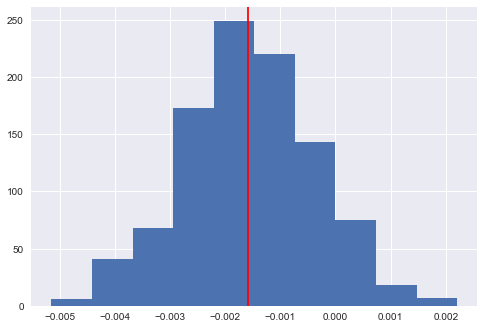

In [51]:
plt.style.use('seaborn')
g=plt.hist(p_diffs);
obs_diffs=df2.query("group=='treatment'")['converted'].mean()-df2.query("group=='control'")['converted'].mean()
h=plt.axvline(x=obs_diffs, color='r')
obs_diffs

<font color='blue'> What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

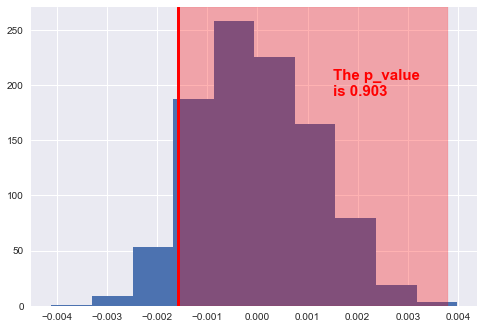

In [52]:
plt.hist(np.random.normal(0,np.std(p_diffs),1000))
plt.axvline(x=obs_diffs, color='r', lw=3)
plt.axvspan(obs_diffs,(np.random.normal(0,np.std(p_diffs),1000)).max(),color='r', alpha=0.3)
plt.text(0.0015,190,"The p_value\nis {}".format((np.random.normal(0,np.std(p_diffs),1000)>obs_diffs).mean()),
         color='r', fontsize=15,weight='bold');

# Conclusion
<font color='red'>*The **P_value** is greater than 0.05, thereby it is evidently under the null hypothesis we can observe a value equal or extremer than in the alternative. We fail to reject the null hypothesis.*

<font color='blue'> Another simplified way to calculate the p_value

In [28]:
import statsmodels.api as sm
convert_old = df2.query("landing_page=='old_page' & converted==1")['converted'].count()
convert_new = df2.query("landing_page=='new_page' & converted==1")['converted'].count()
n_old = df2.query("landing_page=='old_page'")['landing_page'].count()
n_new = df2.query("landing_page=='new_page'")['landing_page'].count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145311)

<font color='blue'>  Now using `stats.proportions_ztest` to compute your test statistic and p-value.

In [29]:
from statsmodels.stats.proportion import proportions_ztest
pvalue = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
pvalue

(-1.3116075339133115, 0.905173705140591)

# Conclusion

<font color='red'>*We got similar p_value which emphasis on our conclusion.*

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

<font color='blue'>what type of regression should you be performing in this case?

<font color='red'>*Logisitc.*

<font color='blue'>​Using **statsmodels** to fit the regression model specified to see if there is a significant difference in conversion based on which page a customer receives.  However, I need to create a column for the intercept, and create a dummy variable column for which page each user received. 

In [43]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


df2['intercept']=1;
df2[['new','old']]=pd.get_dummies(df2['landing_page']);
df2[['control','ab_page']]=pd.get_dummies(df2['group']);

<font color='blue'> Using **statsmodels** to import your regression model anf fit it.

In [44]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

x=df2[['intercept','ab_page']];
y=df2['converted'];
model=sm.Logit(y,x).fit();

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<font color='blue'> Provide the summary of the model below, and use it as necessary to answer the following questions.

In [45]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.6032
Date:               2021-11-07 19:21 BIC:              212801.7625
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290583           LLR p-value:      0.18965    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

<font color='red'>*The regression implies a null hypothesis for the regression parameters which says that the coeffiencts of the these parameters are zero. The values we have in the summary for the p_values enforce impel us to accept the null hypothesis. None of the parameters invesitaged so far has a big influence on the regression model (conversion number).*

<font color='blue'> Now along with testing if the conversion rate changes for different pages, we will check the effect based on which country a user lives. We will read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.

In [46]:
countries_df = pd.read_csv(r'C:\Users\Carnival\AppData\Local\Temp\Rar$DIa7972.8050\countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

<font color='blue'>Checking values in the countries column

In [47]:
df_new['country'].value_counts()

US    203620
UK     72466
CA     14499
Name: country, dtype: int64

<font color='blue'>Create the necessary dummy variables

In [48]:
df_new['intercept']=1;
df_new[['new','old']]=pd.get_dummies(df_new['landing_page']);
df_new[['control','ab_page']]=pd.get_dummies(df_new['group']);
df_new[['US','UK','CA']]=pd.get_dummies(df_new['country']);
df_new['US_ab_page']=df_new['US']*df_new["ab_page"]
df_new['UK_ab_page']=df_new['UK']*df_new["ab_page"]
x_new=df_new[['intercept','US_ab_page','UK_ab_page','ab_page','US','UK']]
y_new=df_new['converted']

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [49]:
model2=sm.Logit(y_new,x_new).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Sun, 07 Nov 2021   Pseudo R-squ.:               3.483e-05
Time:                        19:21:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
US_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page       -0.0206      0.014     -1.506      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
==============================================================================
"""

# Conclusion
<font color='red'>*All the p_values as demonstrated before are above 0.05 which make us fail to reject the null hypothesis. Additionally, the model does not tell us much about the conversion rate according to the parameters included. In short, we dont have enough evidence to support the new page or evict the old one.*